Let's `pip install` real-simple-seismic library.

It's generally form to use jupyter magic like this, I apologize if this messes up your
environment. But; needs must when the devil drives.

In [1]:
%%capture
%pip install real-simple-seismic
%pip install s3fs==0.5.0

In [2]:
from os import getenv
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from time import time

from rss.client import rssFromS3

# Loading AWS Credentials

Here we use the `python-dotenv` library to load our AWS access credentials from a `.env` file contained
in the same folder with our notebooks. iPython magic commands are used here. Keep in mind
if you already have AWS credentials in your environment variables the `.env` will be ignored.

If you already have different credentials and you want to load from the `.env` file, change `%dotenv` magic
function to `%dotenv -o` which will override the existing credentials.

In [4]:
%load_ext dotenv
%dotenv

region_name = 'us-east-1'
aws_key = getenv('AWS_ACCESS_KEY_ID')
aws_secret = getenv('AWS_SECRET_ACCESS_KEY')

client_kwargs = {'aws_access_key_id': aws_key,
                 'aws_secret_access_key': aws_secret}

Connection complete.


# Mounting seismic cube

In [5]:
rss = rssFromS3(
    filename='geophysics-on-cloud/poseidon/seismic/rss/psdn11_TbsdmF_Near_Nov_11_32bit',
    client_kwargs=client_kwargs
)

Connection complete.


# Loading Horizons

In [6]:
%%capture
# load these individually to save memory
horizons = ['water_bottom', 'top_heywood', 'top_johnson', 'top_jameison', 'top_near_plover']
horizon_data = {}
for key in horizons:
    horizon_data[key] = pd.read_csv(
        f's3://geophysics-on-cloud/poseidon/horizons/{key}.csv.gz', 
                              compression='gzip', index_col=[0,1])

# Loading Wells

In [7]:
well_data = pd.read_json(
   path_or_buf='s3://geophysics-on-cloud/poseidon/wells/poseidon_geoml_training_wells.json.gz',
   compression='gzip')

well_data.set_index(['well_id', 'twt'], inplace=True)

# Loading seismic slices using real-simple-seismic

In [8]:
st = time()
inline, mask = rss.line(2002, sort_order='inline')
print ("Elapsed Time (loading) : ", time() - st)

st = time()
inline, mask = rss.line(2003, sort_order='inline')
print ("Elapsed Time (loading): ", time() - st)

st = time()
inline, mask = rss.line(2002, sort_order='inline')
print ("Elapsed Time (caching): ", time() - st)

Elapsed Time (loading) :  2.9163174629211426
Elapsed Time (loading):  2.0878305435180664
Elapsed Time (caching):  0.11009502410888672


# Plot inline

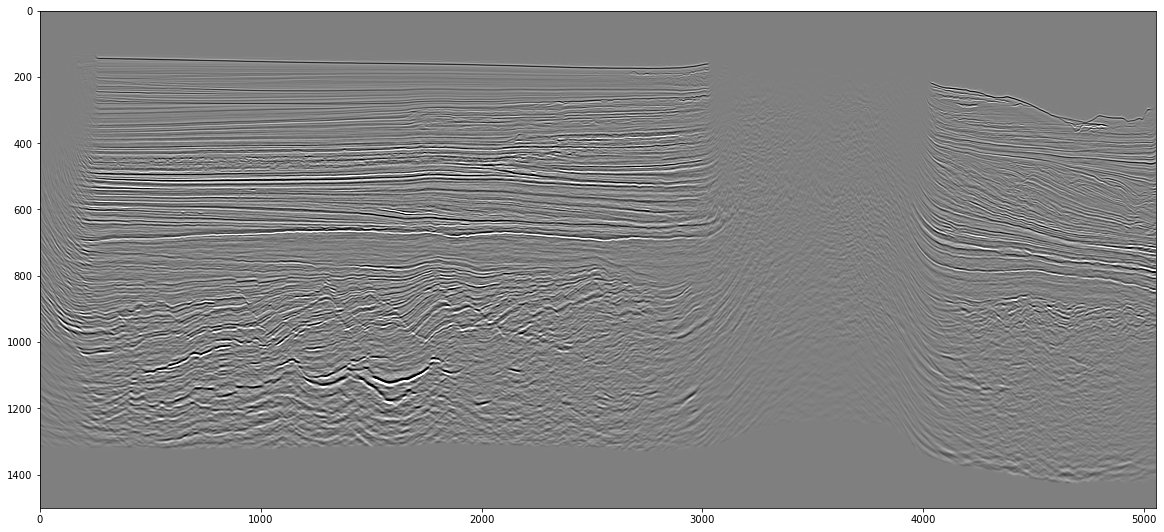

In [9]:
plt.figure(figsize=(20,20))
plt.imshow(inline, cmap='gray', 
           interpolation='bicubic',
           aspect=1.5,
           vmin=-2*np.std(inline[~mask]), vmax=2*np.std(inline[~mask]))
plt.show()

# Plot scatterplot matrix

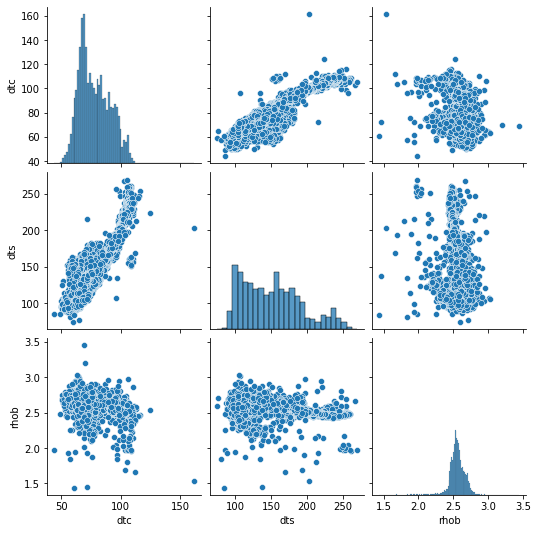

In [10]:
import seaborn as sns
sns.pairplot(well_data[['dtc', 'dts', 'rhob']])

# Plot Horizons

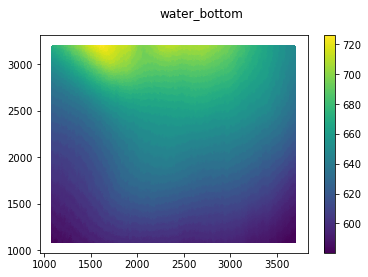

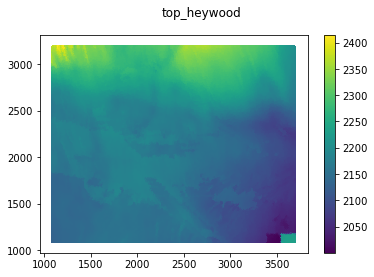

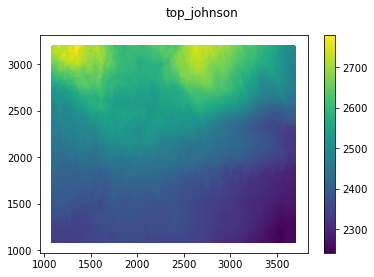

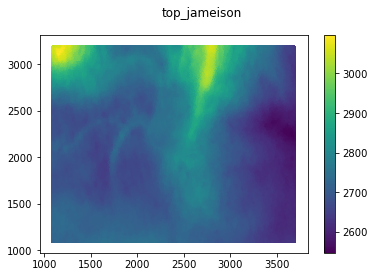

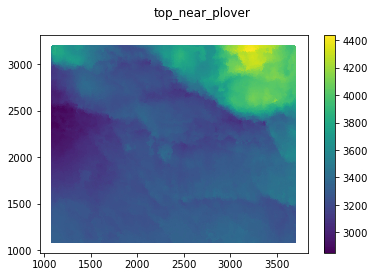

In [11]:
for key, val in horizon_data.items():
    plt.figure()
    plt.suptitle(key)
    plt.tripcolor(
        val.index.get_level_values(0)[::50].values,
        val.index.get_level_values(1)[::50].values,
        val.values[::50,0],
    )
    plt.colorbar()